In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
# Extra 
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/' # project data -- read only                            
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
fname = path_to_data + 'CH2_generated_data/Global_Landslide_Catalog_Export.csv' #TODO check this - is it the raw downloaded data?
landslide = pd.read_csv(fname)

# Select lat/lon grid
lonmin = 65
lonmax = 100
latmin = 20
latmax = 42

## Select Landslides within Southern Asia region
idx = (landslide.latitude >= latmin) & (landslide.latitude <= latmax) & (landslide.longitude >= lonmin) & (landslide.longitude <= lonmax)
landslide = landslide.loc[idx]
# set event time as index
landslide = landslide.set_index(pd.to_datetime(landslide.event_date))
# landslide.index = landslide.index.normalize()

# select only landslide dates that are between december and may
idx = (landslide.index.month >= 12) | (landslide.index.month <= 2)
landslide = landslide[idx]

# rename and reindex
landslide = landslide.rename(columns={"latitude": "lat", "longitude": "lon", "event_date": "event_time"})
landslide = landslide.reset_index()

# round event time to the nearest 6 hours
landslide['time'] = landslide['event_date'].dt.round('6H')
landslide = landslide.set_index(pd.to_datetime(landslide.time))

# select only landslide dates that are between december and may
idx = (landslide.index.month >= 12) | (landslide.index.month <= 2)
landslide = landslide[idx]

idx = (landslide.index >= '2010-02-06 00:00') & (landslide.index <= '2010-02-11 00:00')
# idx = (landslide.index >= '1998-02-12 00:00') & (landslide.index <= '1998-02-17 00:00')
idx = (landslide.index >= '2011-02-10 00:00') & (landslide.index <= '2011-02-17 00:00')
landslide = landslide[idx]
landslide

,event_date,source_name,source_link,event_id,event_time,event_time,event_title,event_description,location_description,location_accuracy,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,lon,lat,time
time,,,,,,,,,,,,,,,,,,,,,
2011-02-13 00:00:00,2011-02-13 00:00:00,Daily News and Analysis,http://www.dnaindia.com/india/report_j-and-k-h...,3116,02/13/2011 12:00:00 AM,NaN,"Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...","Jammu-Srinagar National Highway, connecting Ka...","Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...",25km,...,Kashmir,3278.0,Banihāl,5.78589,09/15/2014 05:13:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.192106,33.33876,2011-02-13 00:00:00
2011-02-16 18:00:00,2011-02-16 18:00:00,greaterkashmir,http://www.greaterkashmir.com/news/2011/Feb/17...,3128,02/16/2011 06:00:00 PM,NaN,"near Ramban, Jammu-Srinagar hwy, Jammu and Kas...",Feb 16: The 300-km Srinagar-Jammu highway whic...,"near Ramban, Jammu-Srinagar hwy, Jammu and Kas...",25km,...,Kashmir,7317.0,Rāmban,2.24620,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.244000,33.26090,2011-02-16 18:00:00
2011-02-13 00:00:00,2011-02-13 00:00:00,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3115,02/13/2011 12:00:00 AM,NaN,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",Fresh snowfall around Jawahar tunnel and lands...,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",5km,...,Kashmir,3278.0,Banihāl,9.75302,09/10/2014 08:01:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.182700,33.30370,2011-02-13 00:00:00
2011-02-13 00:00:00,2011-02-13 00:00:00,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3114,02/13/2011 12:00:00 AM,NaN,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",The Batote-Doda-Kishtwar road was also blocked...,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",5km,...,Kashmir,20553.0,Kishtwār,15.28833,09/10/2014 08:12:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.810100,33.18040,2011-02-13 00:00:00
2011-02-14 00:00:00,2011-02-13 22:00:00,netindian.in,http://netindian.in/news/2011/02/13/00010944/m...,3117,02/13/2011 10:00:00 PM,NaN,trail between Adh Kuwari(Adhkuwari) temple and...,"Jammu, February 13,2011 Three people, includi...",trail between Adh Kuwari(Adhkuwari) temple and...,5km,...,Kashmir,9106.0,Katra,2.96443,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.943700,33.01650,2011-02-14 00:00:00
2011-02-16 18:00:00,2011-02-16 18:00:00,greaterkashmir,http://www.greaterkashmir.com/news/2011/Feb/17...,3127,02/16/2011 06:00:00 PM,NaN,"near Digdol, Jammu-Srinagar hwy, Jammu and Kas...",Feb 16: The 300-km Srinagar-Jammu highway whic...,"near Digdol, Jammu-Srinagar hwy, Jammu and Kas...",5km,...,Kashmir,3278.0,Banihāl,9.75302,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.177400,33.33080,2011-02-16 18:00:00
2011-02-14 00:00:00,2011-02-13 23:00:00,news.in,http://news.in.msn.com/national/article.aspx?c...,3113,02/13/2011 11:00:00 PM,NaN,road between Rajouri(Rajauri) and Poonch(Punch...,The highway was closed for traffic as a portio...,road between Rajouri(Rajauri) and Poonch(Punch...,25km,...,Kashmir,3857.0,Thanna Mandi,18.34095,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.187200,33.57700,2011-02-14 00:00:00


In [4]:
landslide_lats = landslide['lat'].values
landslide_lons = landslide['lon'].values
# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations for d01
ext = [71, 79, 32, 37] # Western precip anomalies
dx = np.arange(round(ext[0], 0),round(ext[1]+1, 0),1)
dy = np.arange(round(ext[2], 0),round(ext[3]+1, 0),1)

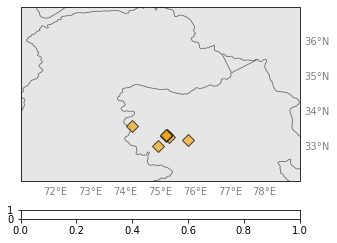

In [5]:
# Create figure
fig = plt.figure(figsize=(5, 5))

nrows=1
ncols=1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='5%',label_mode='',
                direction='row')

for k, ax in enumerate(axgr):  
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=False, right_lats=True, 
                      bottom_lons=True, mask_ocean=False)
    
    for i, (xs, ys) in enumerate(zip(landslide_lons, landslide_lats)):
        ax.plot(xs, ys, alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)

# Show
plt.show()


In [6]:
# Select lat/lon grid
lonmin = 60.2
lonmax = 100
latmin = 16
latmax = 50

lonmin = 71
lonmax = 77
latmin = 32
latmax = 35

In [7]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)


## Import WRF data

In [10]:
def case_precipitation_summary(ar_dict):
    start = ar_dict['start_date']
    end = ar_dict['end_date']
    year = ar_dict['year']
    
    ## Now load data for that AR event
    domains = ['d02', 'd02', 'd01']
    varname_lst = ['prec', 'sr', 'zerodegisotherm']
    res_lst = ['3hr', '3hr', '3hr']


    ## loop through each ds
    ds_lst = []
    for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
        data_path = path_to_data + 'wrf_hasia/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start, end))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        if varname == 'prec':
            # Calculate precipitation rate
            ds = ds.shift(time=-1) - ds # if in xarray
            ## now calculate sum for precipitation for duration of event
            ds = ds.sum('time')
            ds['rain'] = ds.prec - ds.snow
        if varname == 'sr':
        ## now calculate mean frozen fraction for duration of event
            ds = ds.mean('time')
        if varname == 'zerodegisotherm':
        ## now calculate mean zero degree isotherm for duration of event
            ds = ds.mean('time')
            
        ds_lst.append(ds)
        
        
    return ds_lst

In [48]:
## below-average freezing level
below_dict = {'year': 1989,
           'start_date': '1989-01-04 00',
           'end_date': '1989-01-06 12'}

## above-average freezing level
above_dict = {'year': 2010,
           'start_date': '2010-02-06 00',
           'end_date': '2010-02-08 21'}

below_lst = case_precipitation_summary(below_dict)
above_lst = case_precipitation_summary(above_dict)

/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d02/sr/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/sr/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_2010.nc


In [49]:
## Calculate difference: above-avg case - below-avg case
rain_diff = (above_lst[0].rain.values - below_lst[0].rain.values)
snow_diff = (above_lst[0].snow.values - below_lst[0].snow.values)
fraction_diff = (above_lst[1].sr.values - below_lst[1].sr.values)
freezing_diff = (above_lst[-1].z.values - below_lst[-1].z.values)


In [65]:
## create list of arrays to plot
plt_lst = [above_lst[0].rain.values, above_lst[0].snow.values, above_lst[1].sr.values, above_lst[-1].z.values, 
           below_lst[0].rain.values, below_lst[0].snow.values, below_lst[1].sr.values, below_lst[-1].z.values,
           rain_diff, snow_diff, fraction_diff, freezing_diff]

d02_lats = below_lst[0].lat.values
d02_lons = below_lst[0].lon.values

d01_lats = below_lst[-1].lat.values
d01_lons = below_lst[-1].lon.values

cmap = cmo.ice
clipcmap = cmocean.tools.crop_by_percent(cmap, 30, which='min', N=None)

cflevs_lst = [np.arange(2, 212, 10), np.arange(2, 212, 10), np.arange(0, 1.1, .1), np.arange(1500,3100, 100)]*2 + [np.arange(-200, 225, 25), np.arange(-200, 225, 25), np.arange(-1., 1.1, .1), np.arange(-1000,1100, 100)]
cbar_lbl = [r'rain (mm event$^{-1}$)', r'snow (mm event$^{-1}$)', r'fraction of frozen precipitation (-)', r'freezing level height (m ASL)']*2 + [r'$\Delta$ rain (mm event$^{-1}$)', r'$\Delta$ snow (mm event$^{-1}$)', r'$\Delta$ fraction of frozen precipitation (-)', r'$\Delta$ freezing level height (m ASL)']
cmap_lst = [nclc.cmap('WhiteBlueGreenYellowRed'), nclc.cmap('WhiteBlueGreenYellowRed'), clipcmap, cmo.dense]*2 + [cmo.diff_r, cmo.diff_r, cmo.delta_r, cmo.balance]

### WRF Terrain

In [56]:
wrf_filenames = "/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00"
wrfin = nc.Dataset(wrf_filenames)
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height


### Plot Event and Difference Composites

In [57]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# extent of maps
ext2 = [71, 79, 32, 37] # Western precip anomalies

# Set tick/grid locations for d02
dx = np.arange(round(ext2[0], 0),round(ext2[1]+1, 0),1)
dy = np.arange(round(ext2[2], 0),round(ext2[3]+1, 0),1)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

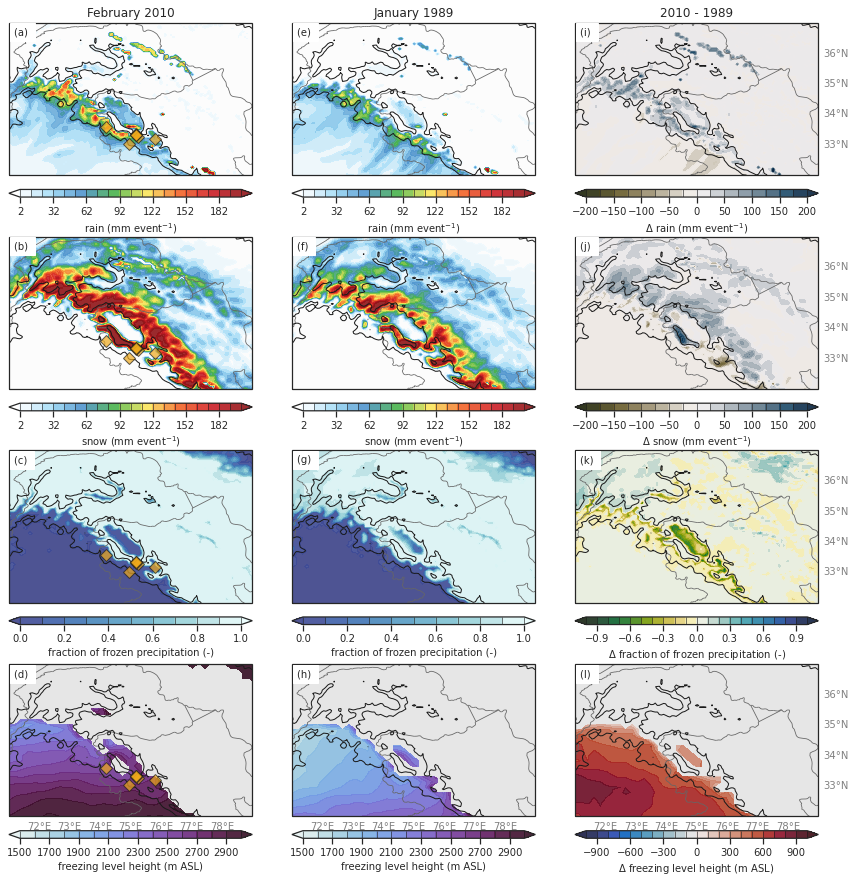

In [69]:
fname = path_to_figs + 'WRF_prec_summary'
fmt = 'png'
nrows = 4
ncols = 3

# point location for (a) (b) (c) label annotation
xpt = 0.02
ypt = 0.97

# hack for tick labels
share_bottom = [False]*3 + [True] + [False]*3 + [True] + [False]*3 + [True]
share_right = [False]*8 + [True]*4

# plot title
plt_ttl = ['February 2010'] + ['']*3 + ['January 1989'] + ['']*3 + ['2010 - 1989'] + ['']*3

# Create figure
fig = plt.figure(figsize=(15,15))
nrows = 4
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='each',
                cbar_pad=0.2, cbar_size='5%',label_mode='',
                direction='column')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
    
    if (k == 3) | (k == 7) | (k == 11):
        lats = d01_lats
        lons = d01_lons
    else:
        lats = d02_lats
        lons = d02_lons
    
    # Contour Filled
    cf = ax.contourf(lons, lats, plt_lst[k], transform=datacrs,
                     levels=cflevs_lst[k], cmap=cmap_lst[k], alpha=0.9, extend='both')
    
    # Contour Lines (terrain)
    terclevs=np.array([1000, 3000])
    terlons = terrain.XLONG.values
    terlats = terrain.XLAT.values
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
     # add landslide points to 2010 case
    if (k < 4):
        for i, (xs, ys) in enumerate(zip(landslide_lons, landslide_lats)):
            ax.plot(xs, ys, alpha=0.7, marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)
    
    ttl = "({0}) ".format(letter_lst[k])
    ax.text(xpt, ypt, ttl, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)
    ax.set_title(plt_ttl[k], loc='center',fontsize=12)
    
    # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[k], orientation='horizontal', drawedges=True)
    cb.set_label(cbar_lbl[k], fontsize=10)
    cb.ax.tick_params(labelsize=10)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
